In [1]:
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import pandas as pd

from popy.io_tools import *
from popy.behavior_data_tools import *
from popy.neural_data_tools import time_normalize_session, scale_neural_data, remove_low_fr_neurons, remove_trunctuated_neurons
#from popy.decoders import *
from popy.plotting.plotting_tools import *
from popy.decoding.population_decoders import preproc_data, build_dataset

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, LeaveOneOut

# event times
def get_event_times(neural_data):
    n_temp = neural_data[:, neural_data.trial_id==neural_data.trial_id[0]]
    bin_size = neural_data.attrs['bin_size']
    epochs = np.unique(n_temp.epoch_id.values)
    ep_lens = np.array([len(n_temp[:, n_temp.epoch_id==epoch].time) for epoch in epochs])
    ep_lens = ep_lens * bin_size
    ep_lens = np.cumsum(ep_lens)
    ep_lens = np.insert(ep_lens, 0, 0)

    events = {'trial_start': ep_lens[0], 
              'lever_touch': ep_lens[1],
              'lever_validation': ep_lens[2],
              'target_touch': ep_lens[3],
              'target_validation': ep_lens[4],
              'feedback': ep_lens[5],
              'trial_end': ep_lens[6]}

    return events

# Load and fromat data

In [2]:
monkey, session = 'ka', '020622'
area = 'LPFC'

## Behav data

In [3]:
session_data = get_behavior(monkey, session)
session_data = add_value_function(session_data, monkey=monkey, digitize=False)
session_data['value_function_continous'] = session_data['value_function']
session_data = add_value_function(session_data, monkey=monkey, digitize=True, n_classes=4)
    
# shift value function by 1 trial
session_data['value_function'] = session_data['value_function'].shift(-1)
session_data['value_function_continous'] = session_data['value_function_continous'].shift(-1)
session_data['target'] = session_data['target'].shift(-1)

for i in range(3):
    session_data['target_1'] = session_data['target'] == 1
    session_data['target_2'] = session_data['target'] == 2
    session_data['target_3'] = session_data['target'] == 3

In [4]:
# clean up data
session_data = drop_time_fields(session_data)  # remove time fields
if 'block_id' in session_data.columns:
    session_data = session_data.drop(columns=['block_id'])
if 'best_target' in session_data.columns:
    session_data = session_data.drop(columns=['best_target'])
session_data = session_data.dropna()

# remove phase not 'repeat'
#session_data = session_data[session_data.phase == 'repeat']

session_data

,monkey,session,trial_id,target,feedback,value_function,value_function_continous,target_1,target_2,target_3
4,ka,020622,4,2.0,False,1.0,0.386276,False,True,False
5,ka,020622,5,2.0,True,2.0,0.658602,False,True,False
6,ka,020622,6,2.0,True,3.0,0.810090,False,True,False
7,ka,020622,7,2.0,False,1.0,0.450630,False,True,False
8,ka,020622,8,2.0,True,2.0,0.694401,False,True,False
...,...,...,...,...,...,...,...,...,...,...
335,ka,020622,335,3.0,True,3.0,0.854968,False,False,True
336,ka,020622,336,3.0,True,3.0,0.919323,False,False,True
337,ka,020622,337,3.0,False,1.0,0.486429,False,False,True
338,ka,020622,338,3.0,True,2.0,0.739279,False,False,True


## Neural data

In [5]:
# Load neural data
neural_data = load_neural_data(monkey, session, 'rates')

# get area
area_ids = np.where(neural_data.area.data == area)[0]
neural_data = neural_data[area_ids, :]

# conservative restrictions
neural_data = remove_trunctuated_neurons(neural_data, delay_limit=10)  # remove neurons with trunctuated activity
neural_data = remove_drift_neurons(neural_data, corr_limit=.2)  # remove neurons with drift
neural_data = remove_low_fr_neurons(neural_data, 1)  # remove low_firing units

# normalize neural data in time
neural_data = time_normalize_session(neural_data)  # normalize neural data in time to get uniform trial length
neural_data = scale_neural_data(neural_data)  # scale neural data (z-score)

neural_data

<xarray.DataArray (unit: 14, time: 255750)>
array([[-4.6799290e-01,  2.9404783e+00, -4.9200463e-01, ...,
         1.4622871e+00,  1.6144211e+00,  1.7697295e+00],
       [ 3.0412984e+00, -7.0020747e-01, -7.0020747e-01, ...,
        -6.9474226e-01, -6.8925333e-01, -6.7909092e-01],
       [ 4.0591425e-01, -6.8090230e-01, -3.6597115e-01, ...,
         8.0147761e-01,  5.6610686e-01,  3.5939139e-01],
       ...,
       [-6.0721719e-01,  3.1550837e-01, -6.8203330e-01, ...,
         6.3123177e-03,  3.2523982e-02,  7.7117153e-02],
       [-5.7332128e-01, -5.7337302e-01, -5.7337302e-01, ...,
         9.2040174e-02, -8.5426547e-02, -2.2760054e-01],
       [ 8.5988531e+00, -2.1894495e-01,  3.1219145e-02, ...,
        -2.2689684e-01, -2.2687460e-01, -2.2683878e-01]], dtype=float32)
Coordinates:
    trial_id          (time) float64 0.0 0.0 0.0 0.0 ... 340.0 340.0 340.0 340.0
    epoch_id          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0 5.0
  * unit              (unit) object 'LPFC_06_01' 'LPFC_07_01' ... 'LPFC_16_01'
    area              (unit) object 'LPFC' 'LPFC' 'LPFC' ... 'LPFC' 'LPFC'
    unit_id_original  (unit) int32 7 17 24 28 25 78 30 32 45 82 81 59 85 69
    channel           (unit) int32 6 7 11 12 12 13 13 13 14 14 14 15 15 16
  * time              (time) float64 8.01 10.87 13.74 ... 2.824e+03 2.824e+03
Attributes:
    bin_size:  0.01

## Create dataset

In [6]:
# create dataset
neural_data_np, labels = build_dataset(neural_data, session_data, n_extra_trials=1)

neural_data_np.shape, labels.shape

((336, 14, 1500), (336, 10))

# Find target subspace

In [7]:
def mean_defined_decision_vector(X, y):
    mean_target_of_interest = np.mean(X[y==True], axis=0)
    mean_other_targets = np.mean(X[y==False], axis=0)

    normal_vector = mean_target_of_interest - mean_other_targets
    normal_vector = normal_vector / np.linalg.norm(normal_vector)

    return normal_vector

def decoder_defined_decision_vector(X, y):
    from sklearn.linear_model import LogisticRegression

    # balance data
    from imblearn.under_sampling import RandomUnderSampler
    rus = RandomUnderSampler()
    X_balanced, y_balanced = rus.fit_resample(X, y)

    clf = LogisticRegression()
    clf.fit(X_balanced, y_balanced)

    return clf.coef_

In [8]:
# initialize scores and weights
n_time_bins = neural_data_np.shape[2]
n_units = neural_data_np.shape[1]
n_trials = neural_data_np.shape[0]
weights = np.empty((n_time_bins, n_units, 3))

for i_target, target in enumerate(['target_1', 'target_2', 'target_3']):
    # preprocess data
    X, y = neural_data_np, labels[target].values
    
    normal_vectors = np.empty((n_time_bins, n_units))
    for t_train in range(0, n_time_bins):
        X_temp = X[:, :, t_train]

        #normal_vector = mean_defined_decision_vector(X_temp, y)
        normal_vector = decoder_defined_decision_vector(X_temp, y)
        
        normal_vectors[t_train, :] = normal_vector
    weights[:, :, i_target] = normal_vectors

weights.shape, neural_data_np.shape

((1500, 14, 3), (336, 14, 1500))

In [9]:
'''weights[:, :, :] = 0
weights[:, 5, :] = 1
plt.imshow(weights[:, :, 0], aspect='auto')'''

"weights[:, :, :] = 0\nweights[:, 5, :] = 1\nplt.imshow(weights[:, :, 0], aspect='auto')"

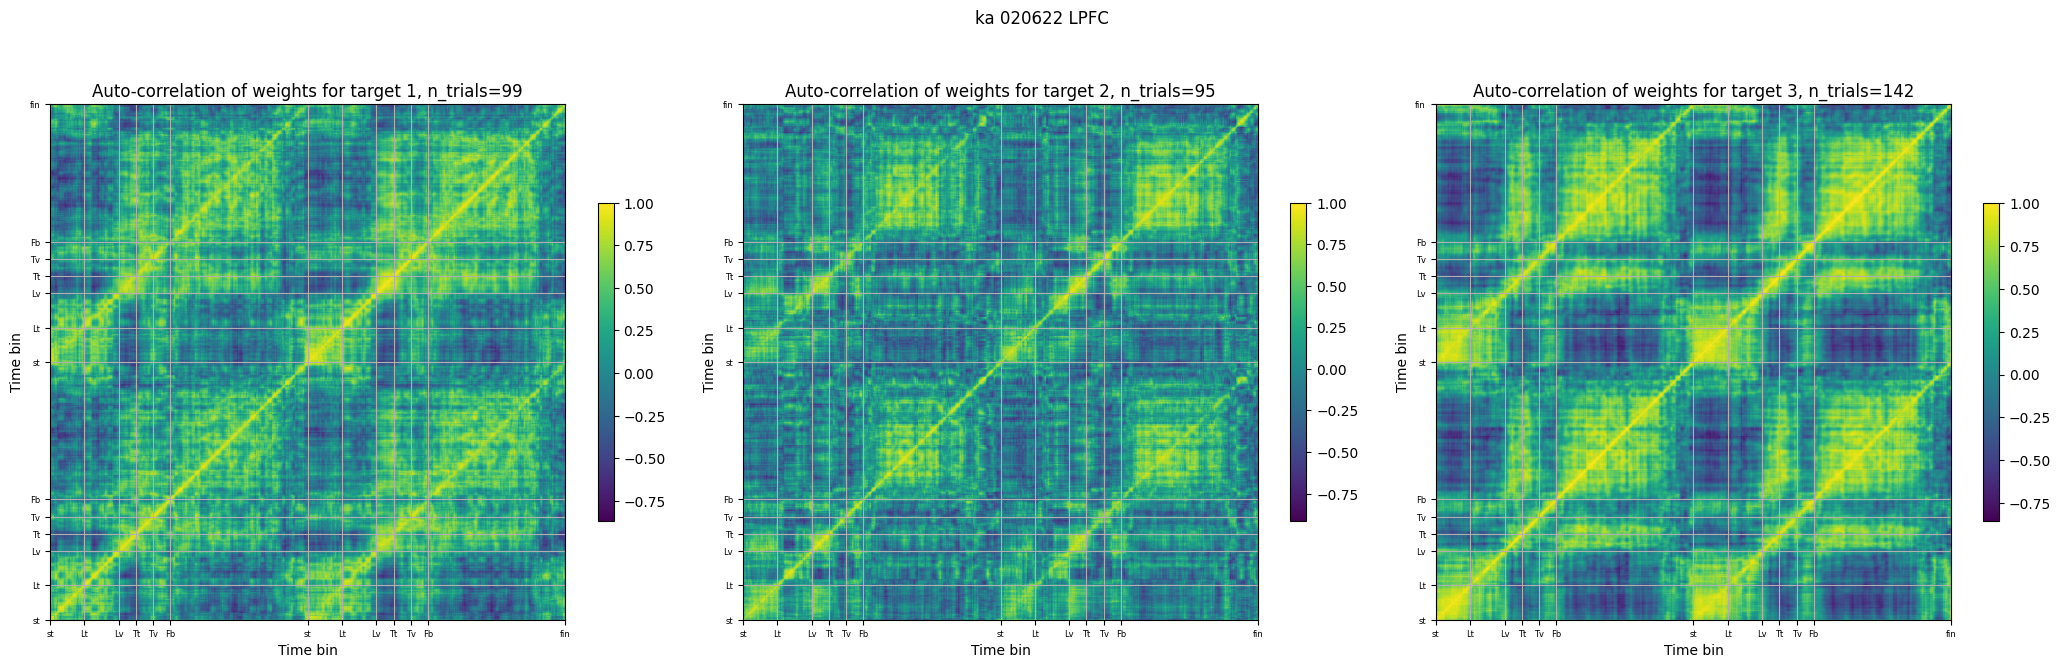

In [10]:
# plot auto-correlation of weights

fig, axs = plt.subplots(1, 3, figsize=(21, 7))


for i in range(3):
    vector = weights[:, :, i]
    ax = axs[i]
    
    cbar = ax.imshow(np.corrcoef(vector), cmap='viridis', origin='lower', extent=[0, 15, 0, 15])
    fig.colorbar(cbar, ax=ax, shrink=0.5)
    ax.set_title(f'Auto-correlation of weights for target {i+1}, n_trials={np.count_nonzero(labels[f"target_{i+1}"])}')
    ax.set_xlabel('Time bin')
    ax.set_ylabel('Time bin')

    plot_keypoints(ax, fontsize=6, axis='both')
    ax.grid(axis='both')

plt.suptitle(f'{monkey} {session} {area} ')
plt.tight_layout()
plt.show()


## Project data to best subspace

In [11]:
# create dataset
neural_data_projected = np.empty((n_trials, 3, n_time_bins))

for t in range(n_time_bins):
    neural_data_projected[:, :, t] = np.dot(neural_data_np[:, :, t], weights[t, :, :])

neural_data_projected.shape

(336, 3, 1500)

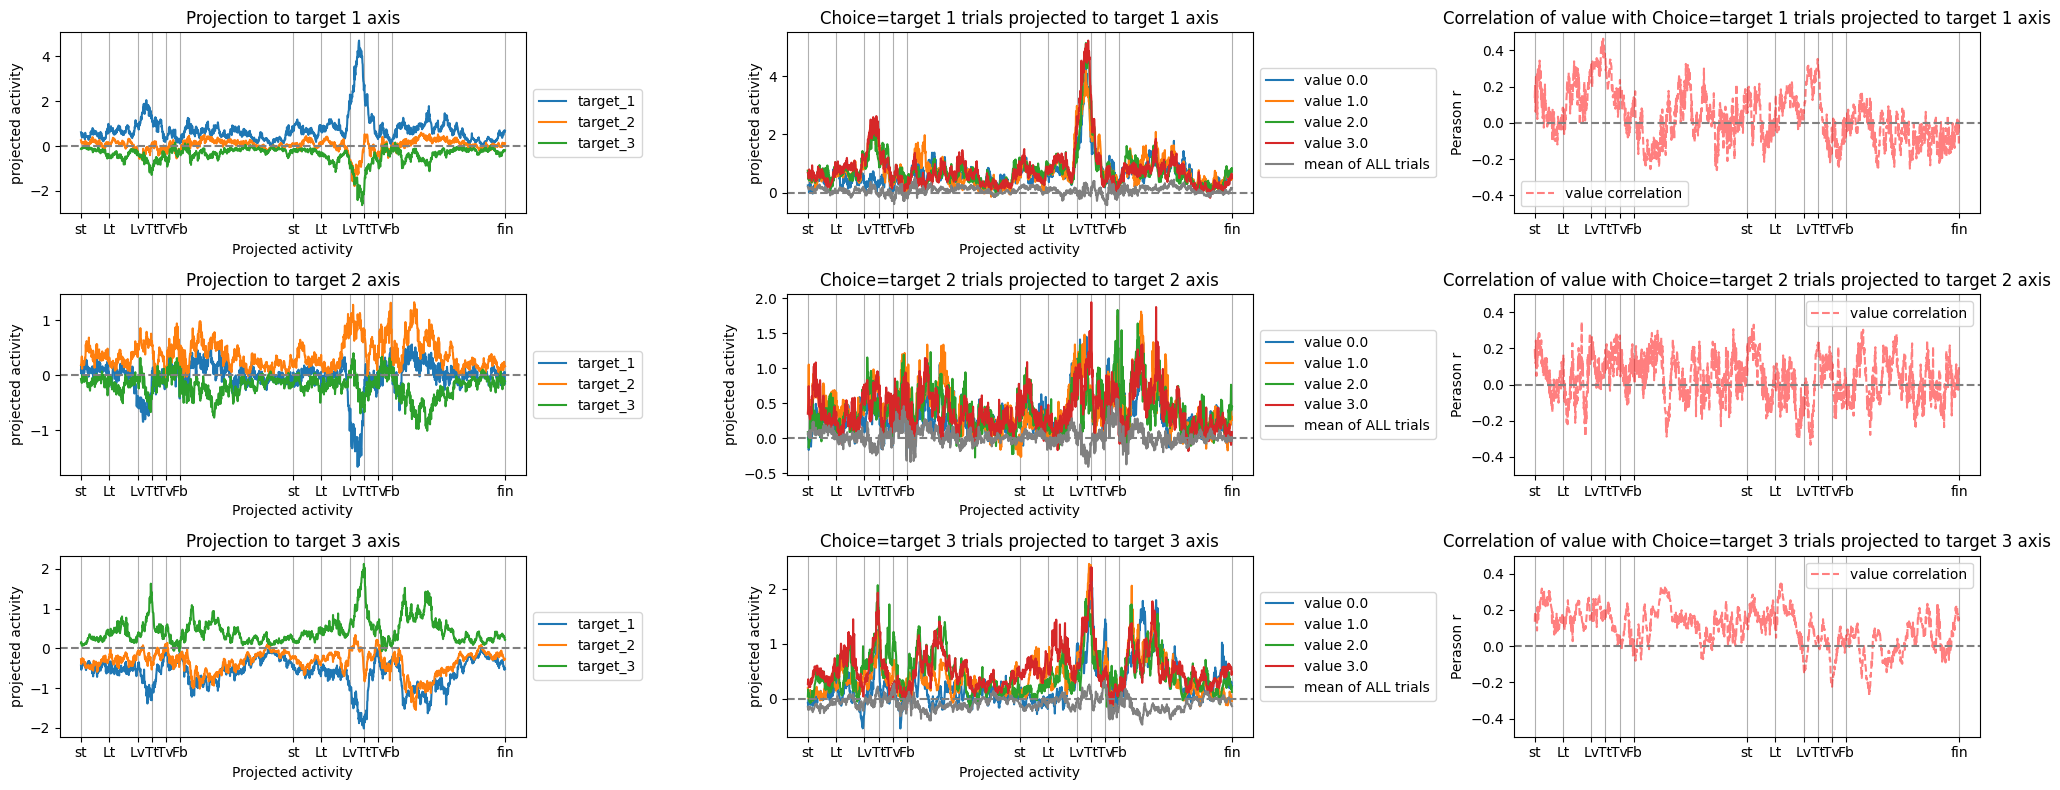

In [12]:
# measure value of projection at time 225 and correlate with value function
values = labels['value_function'].values
values_continuous = labels['value_function_continous'].values
targets = labels['target'].values

fig, axs = plt.subplots(3, 3, figsize=(20, 8))
time_vector = np.arange(neural_data_projected.shape[2]) * neural_data.attrs['bin_size']

# plot projection of each target on the given rotating axis
for i_target, target in enumerate(['target_1', 'target_2', 'target_3']):
    ax = axs[i_target, 0]

    # plot mean projection per target
    ax.plot(time_vector, neural_data_projected[targets == 1, i_target, :].mean(axis=0), label='target_1', color='C0')
    ax.plot(time_vector, neural_data_projected[targets == 2, i_target, :].mean(axis=0), label='target_2', color='C1')
    ax.plot(time_vector, neural_data_projected[targets == 3, i_target, :].mean(axis=0), label='target_3', color='C2')

    ax.axhline(0, color='gray', linestyle='--')

    ax.set_title(f'Projection to target {i_target+1} axis')
    ax.set_xlabel('Projected activity')
    ax.set_ylabel('projected activity')
    plot_keypoints(ax)
    ax.grid(axis='x')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plot value modulated target projection
for i_target, target in enumerate(['target_1', 'target_2', 'target_3']):
    ax = axs[i_target, 1]
   
    # plot mean projection per target, grouped by value
    idx_target = targets == i_target+1
    for value_level in np.unique(values):
        idx_value = values == value_level
        idx = idx_target & idx_value
        ax.plot(time_vector, neural_data_projected[idx, i_target, :].mean(axis=0), label=f'value {value_level}', color=f'C{int(value_level)}')

    # plot mean projection per target, all trials
    ax.plot(time_vector, neural_data_projected[:, i_target, :].mean(axis=0), label=f'mean of ALL trials', color='gray')

    # zero line
    ax.axhline(0, color='gray', linestyle='--')

    ax.set_title(f'Choice=target {i_target+1} trials projected to target {i_target+1} axis')
    ax.set_xlabel('Projected activity')
    ax.set_ylabel('projected activity')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plot_keypoints(ax)
    ax.grid(axis='x')

# plot value modulated target projection
for i_target, target in enumerate(['target_1', 'target_2', 'target_3']):
    ax = axs[i_target, 2]
   
    # plot mean projection per target, grouped by value
    idx_target = targets == i_target+1
    # plot value correlation with projection in time (only this targets trials)
    corrs = [np.corrcoef(neural_data_projected[idx_target, i_target, t], values_continuous[idx_target])[0, 1] for t in range(n_time_bins)]
    ax.plot(time_vector, corrs, label='value correlation', color='red', alpha=.5, linestyle='--')
    ax.set_ylabel('value correlation')
    ax.set_ylim(-.5, .5)

    # zero line
    ax.axhline(0, color='gray', linestyle='--')

    ax.set_title(f'Correlation of value with Choice=target {i_target+1} trials projected to target {i_target+1} axis')
    ax.set_ylabel('Perason r')
    ax.legend()

    plot_keypoints(ax)
    ax.grid(axis='x')

plt.tight_layout()

# Value subspace per target

In [13]:
# create dataset
neural_data_np, labels = build_dataset(neural_data, session_data, n_extra_trials=1)

neural_data_np.shape, labels.shape

# initialize scores and weights
n_time_bins = neural_data_np.shape[2]
n_units = neural_data_np.shape[1]
n_trials = neural_data_np.shape[0]

In [14]:
from sklearn.metrics import mean_absolute_error

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def scoring(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


In [15]:
def time_resolved_decoder(X, y, model):
    kf = KFold(n_splits=10, shuffle=True)

    n_time_bins = X.shape[2]

    # decode at each time point
    res_same_trials = np.empty(n_time_bins)
    res_curr_target = np.empty(n_time_bins)
    #res_diff_target = np.empty(n_time_bins)
    for t_idx, time in enumerate(range(n_time_bins)):
        if not t_idx % 10 == 0:  # skip some time points
            continue

        # cross validate model
        res_same, res_curr, res_diff = [], [], []
        #y_pred_same, y_pred_curr, y_pred_diff = [], [], []
        #y_true_same, y_true_curr, y_true_diff = [], [], []
        for train_index, test_curr_index in kf.split(X):
            #test_diff_index = np.random.choice(X_diff.shape[0], len(test_curr_index), replace=False)  # sample same number of test trials from different target trials

            X_train_same = X[train_index, :, t_idx]
            y_train_same = y[train_index]
            X_test_curr = X[test_curr_index, :, t_idx]
            y_test_curr = y[test_curr_index]
            #X_test_diff = X_diff[test_diff_index, :, t_idx]
            #y_test_diff = y_diff[test_diff_index]

            #model = LinearRegression().fit(X_train_same, y_train_same)
            model.fit(X_train_same, y_train_same)
            res_same.append(model.score(X_train_same, y_train_same))  # same train and test set
            res_curr.append(model.score(X_test_curr, y_test_curr))  # same target on train and test set, but trials are different
            #res_diff.append(model.score(X_test_diff, y_test_diff))  # train and test set on different target
        res_same_trials[t_idx] = np.mean(res_same)
        res_curr_target[t_idx] = np.mean(res_curr)

    return res_same_trials, res_curr_target

In [16]:
import xarray as xr
weights = np.empty((n_time_bins, n_units, 3))

parameters = {'alpha': np.linspace(0.001, .07, 5), 'model': [Lasso()]}
n_params = len(parameters['alpha'])*len(parameters['model'])

data = xr.DataArray(
    np.empty((3, n_time_bins, n_params)),
    coords={'mode': ['train_set', 'test_1', 'test_2'], 
            'time': time_vector, 
            'alpha': (['parameters'], np.empty(n_params)),
            'model': (['parameters'], ['' for i in range(n_params)]),
            },
    dims=['mode', 'time', 'parameters']
)

for i_target, target in enumerate(['target_1', 'target_2', 'target_3']):

    if not i_target == 1:
        continue
            
    # preprocess data
    curr_target_ids = labels[target].values == True
    #curr_target_ids = np.random.choice(neural_data_np.shape[0], neural_data_np.shape[0]//3, replace=False)
    X_curr = neural_data_np[curr_target_ids, :, :]
    y_curr = labels['value_function_continous'].values[curr_target_ids]
    #X_diff = neural_data_np[~curr_target_ids, :, :]
    #y_diff = labels['value_function_continous'].values[~curr_target_ids]

    param_count = 0
    for model in parameters['model']:
        for alpha in parameters['alpha']:
            model = model.set_params(alpha=alpha)
            res_train, res_test = time_resolved_decoder(X_curr, y_curr, model)

            data[0, :, param_count] = res_train
            data[1, :, param_count] = res_test

            data.alpha[param_count] = alpha
            data.model[param_count] = model

            param_count += 1      


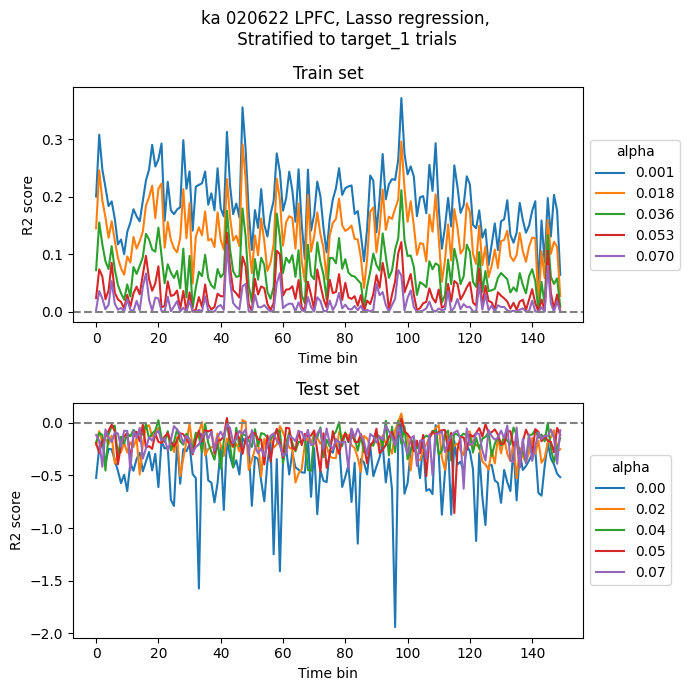

In [17]:
alphas, models = data.alpha.values, data.model.values
fig, axs = plt.subplots(2, 1, figsize=(7, 7))
plt.suptitle(f'{monkey} {session} {area}, Lasso regression,\n Stratified to target_1 trials')
axs[0].plot(data[0, ::10, :], label=[f'{alpha:.3f}' for alpha, model in zip(alphas, models)])
axs[1].plot(data[1, ::10, :], label=[f'{alpha:.2f}' for alpha, model in zip(alphas, models)])

axs[0].axhline(0, color='gray', linestyle='--')
axs[1].axhline(0, color='gray', linestyle='--')

axs[0].legend(title='alpha', loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].legend(title='alpha', loc='center left', bbox_to_anchor=(1, 0.5))

axs[0].set_title('Train set')
axs[1].set_title('Test set')

axs[0].set_xlabel('Time bin')
axs[1].set_xlabel('Time bin')
axs[0].set_ylabel('R2 score')
axs[1].set_ylabel('R2 score')

plt.tight_layout()

NameError: name 'res_same_trials' is not defined

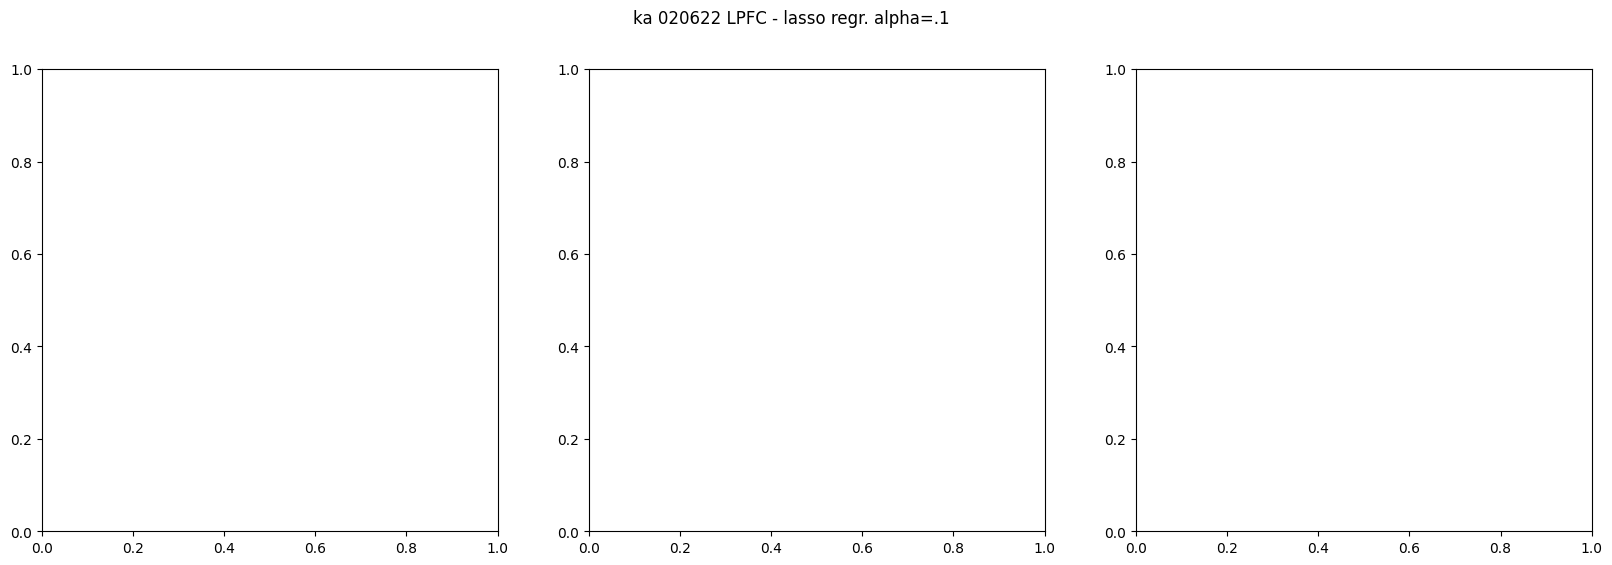

In [18]:

# plot decoding results
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
plt.suptitle(f'{monkey} {session} {area} - lasso regr. alpha=.1')
time_vector = np.arange(neural_data_np.shape[2]) * neural_data.attrs['bin_size']

for i_target, target in enumerate(['target_1', 'target_2', 'target_3']):
    if not i_target == 0:
        continue

    # plot results
    ax = axs[i_target]

    # plot mean projection per target
    ax.plot(time_vector[::10], res_same_trials[::10, i_target], label='train trials', color='C0', alpha=.8)
    ax.plot(time_vector[::10], res_curr_target[::10, i_target], label='same target trials', color='C1', alpha=.8)
    ax.plot(time_vector[::10], res_diff_target[::10, i_target], label='different target trials', color='C2', alpha=.8)

    ax.set_title(f'Value decoding, trials of choice= target_{i_target+1}')
    #ax.set_title(f'Value decoding, random 1/3rd of trials')

    ax.set_xlabel('Time')
    ax.set_ylabel('R^2')
    plot_keypoints(ax)
    ax.grid(axis='x')

    ax.set_ylim(-.7, .7)
    ax.axhline(0, color='gray', linestyle='--')
    ax.legend()


/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeW

target_1 vs target_2: nan
target_1 vs target_3: nan
target_2 vs target_3: nan


/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeW

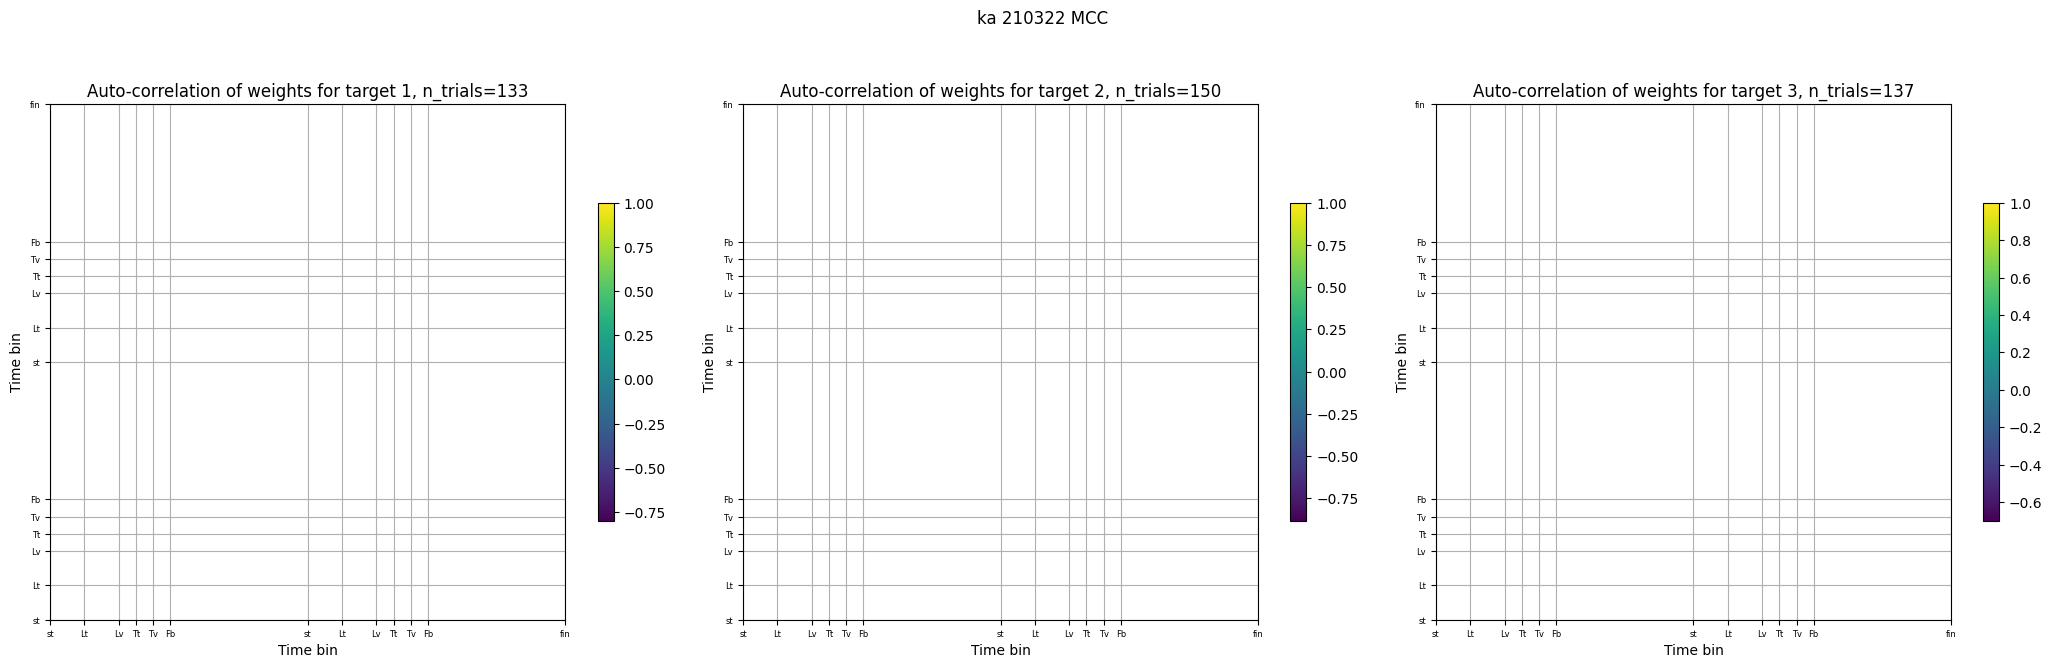

In [ ]:
# plot auto-correlation of weights

fig, axs = plt.subplots(1, 3, figsize=(21, 7))
time_vector = np.arange(neural_data_projected.shape[2]) * neural_data.attrs['bin_size']

print(f'target_1 vs target_2: {np.corrcoef(weights[:, :, 0], weights[:, :, 1])[0, 1]}')
print(f'target_1 vs target_3: {np.corrcoef(weights[:, :, 0], weights[:, :, 2])[0, 1]}')
print(f'target_2 vs target_3: {np.corrcoef(weights[:, :, 1], weights[:, :, 2])[0, 1]}')

for i in range(3):
    vector = weights[:, :, i]
    ax = axs[i]
    
    cbar = ax.imshow(np.corrcoef(vector), cmap='viridis', origin='lower', extent=[0, 15, 0, 15])
    fig.colorbar(cbar, ax=ax, shrink=0.5)
    ax.set_title(f'Auto-correlation of weights for target {i+1}, n_trials={np.count_nonzero(labels[f"target_{i+1}"])}')
    ax.set_xlabel('Time bin')
    ax.set_ylabel('Time bin')

    plot_keypoints(ax, fontsize=6, axis='both')
    ax.grid(axis='both')

plt.suptitle(f'{monkey} {session} {area} ')
plt.tight_layout()
plt.show()


In [ ]:

# create dataset
neural_data_projected = np.empty((n_trials, 3, n_time_bins))

for t in range(n_time_bins):
    neural_data_projected[:, :, t] = np.dot(neural_data_np[:, :, t], weights[t, :, :])

neural_data_projected.shape

(420, 3, 1500)

/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/l

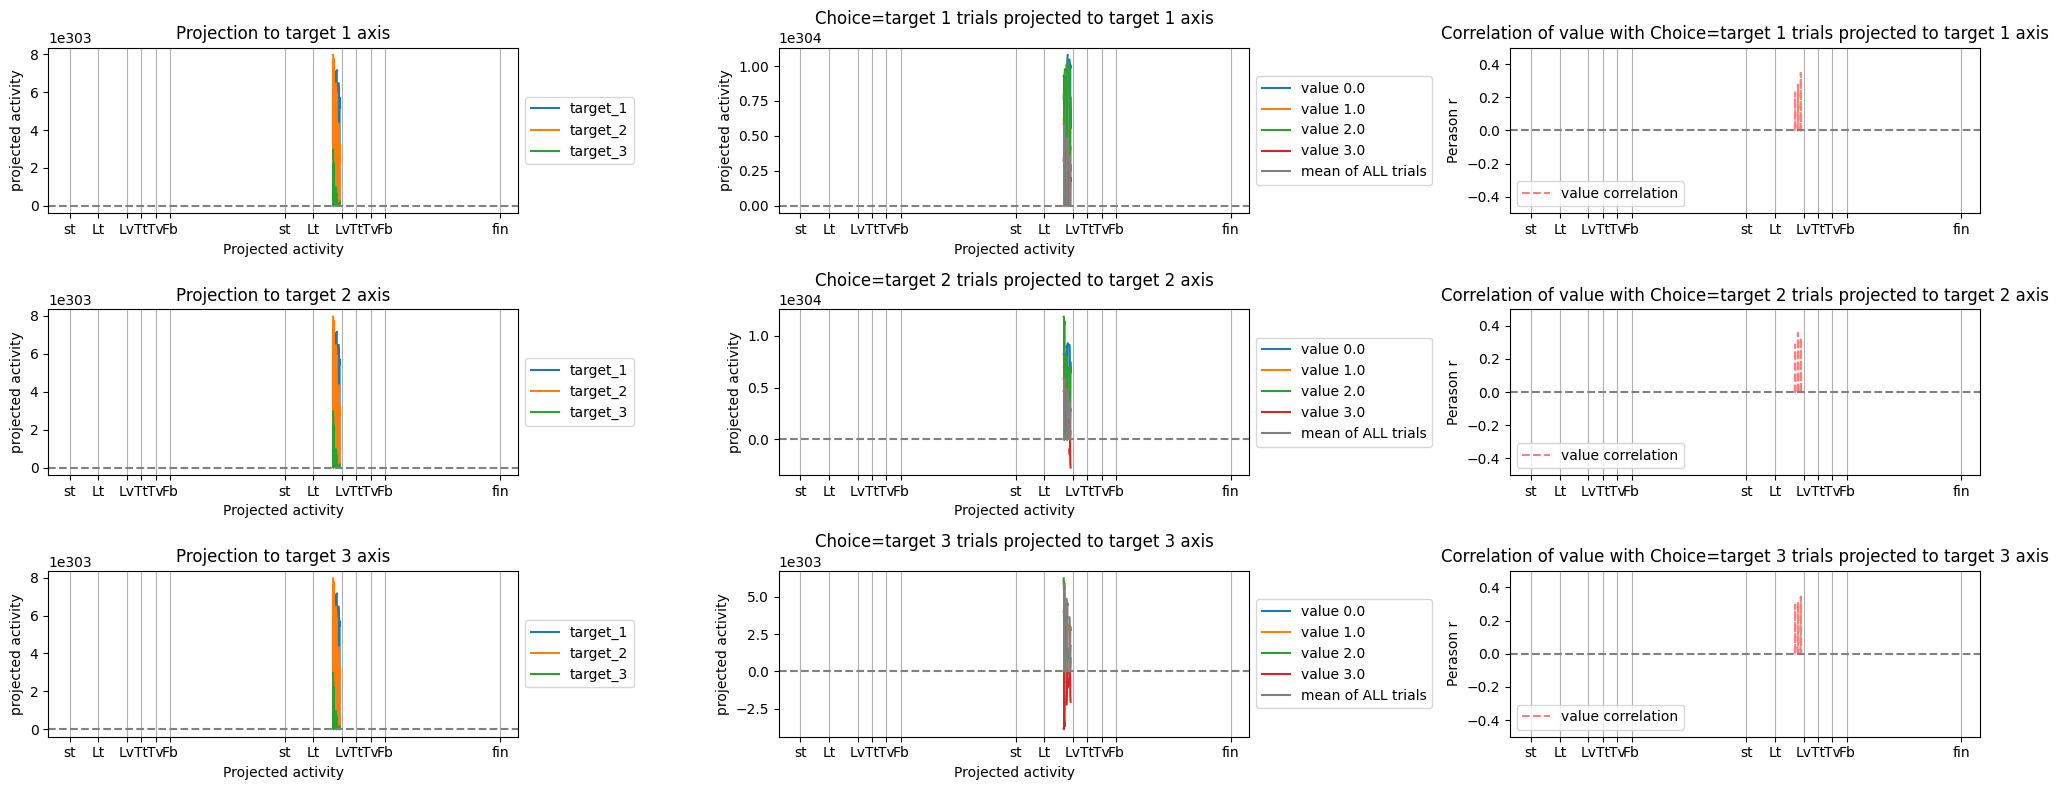

In [ ]:
# measure value of projection at time 225 and correlate with value function
values = labels['value_function'].values
values_continuous = labels['value_function_continous'].values
targets = labels['target'].values

fig, axs = plt.subplots(3, 3, figsize=(20, 8))
time_vector = np.arange(neural_data_projected.shape[2]) * neural_data.attrs['bin_size']

# plot projection of each target on the given rotating axis
for i_target, target in enumerate(['target_1', 'target_2', 'target_3']):
    ax = axs[i_target, 0]

    # plot mean projection per target
    ax.plot(time_vector, neural_data_projected[targets == 1, i_target, :].mean(axis=0), label='target_1', color='C0')
    ax.plot(time_vector, neural_data_projected[targets == 2, i_target, :].mean(axis=0), label='target_2', color='C1')
    ax.plot(time_vector, neural_data_projected[targets == 3, i_target, :].mean(axis=0), label='target_3', color='C2')

    ax.axhline(0, color='gray', linestyle='--')

    ax.set_title(f'Projection to target {i_target+1} axis')
    ax.set_xlabel('Projected activity')
    ax.set_ylabel('projected activity')
    plot_keypoints(ax)
    ax.grid(axis='x')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plot value modulated target projection
for i_target, target in enumerate(['target_1', 'target_2', 'target_3']):
    ax = axs[i_target, 1]
   
    # plot mean projection per target, grouped by value
    idx_target = targets == i_target+1
    for value_level in np.unique(values):
        idx_value = values == value_level
        idx = idx_target & idx_value
        ax.plot(time_vector, neural_data_projected[idx, i_target, :].mean(axis=0), label=f'value {value_level}', color=f'C{int(value_level)}')

    # plot mean projection per target, all trials
    ax.plot(time_vector, neural_data_projected[:, i_target, :].mean(axis=0), label=f'mean of ALL trials', color='gray')

    # zero line
    ax.axhline(0, color='gray', linestyle='--')

    ax.set_title(f'Choice=target {i_target+1} trials projected to target {i_target+1} axis')
    ax.set_xlabel('Projected activity')
    ax.set_ylabel('projected activity')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plot_keypoints(ax)
    ax.grid(axis='x')

# plot value modulated target projection
for i_target, target in enumerate(['target_1', 'target_2', 'target_3']):
    ax = axs[i_target, 2]
   
    # plot mean projection per target, grouped by value
    idx_target = targets == i_target+1
    # plot value correlation with projection in time (only this targets trials)
    corrs = [np.corrcoef(neural_data_projected[idx_target, i_target, t], values_continuous[idx_target])[0, 1] for t in range(n_time_bins)]
    ax.plot(time_vector, corrs, label='value correlation', color='red', alpha=.5, linestyle='--')
    ax.set_ylabel('value correlation')
    ax.set_ylim(-.5, .5)

    # zero line
    ax.axhline(0, color='gray', linestyle='--')

    ax.set_title(f'Correlation of value with Choice=target {i_target+1} trials projected to target {i_target+1} axis')
    ax.set_ylabel('Perason r')
    ax.legend()

    plot_keypoints(ax)
    ax.grid(axis='x')

plt.tight_layout()

# OLD

In [ ]:
# plot target 1 selection in its subspace
target = 2
target_ids = session_data[f'target_{target+1}'].values

neural_data_curr = projection[:, target, :]
values = session_data['value_function'].values
rewards = session_data['feedback'].values
targets = session_data['target'].values

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, trial in enumerate(neural_data_curr):
    ax.plot(np.linspace(0, 7.5, len(trial)), trial, color='b' if targets[i] == target+1 else 'r', alpha=.01)

# plot mean of positive and negative feedbacks
ax.plot(np.linspace(0, 7.5, len(trial)), np.mean(neural_data_curr[targets == 1], axis=0), lw=3, label='target 1')
ax.plot(np.linspace(0, 7.5, len(trial)), np.mean(neural_data_curr[targets == 2], axis=0), lw=3, label='target 2')
ax.plot(np.linspace(0, 7.5, len(trial)), np.mean(neural_data_curr[targets == 3], axis=0), lw=3, label='target 3')

ax.axhline(0, color='r', linestyle='--')
plot_keypoints(ax)
ax.grid(axis='x', linestyle='--', color='b', lw=3)
ax.set_ylim(-10, 10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neural activity')
ax.set_title(f'Neural activity projection for target {target+1} subspace')
ax.legend()

NameError: name 'projection' is not defined

In [ ]:
# plot target 1 selection in its subspace
target = 3

neural_data_curr = projection[:, target-1, :]
values = session_data['value_function'].values
rewards = session_data['feedback'].values
targets = session_data['target'].values

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot mean of positive and negative feedbacks
ax.plot(np.linspace(0, 7.5, len(trial)), np.mean(neural_data_curr[(targets == 3) & (feedbacks == 1)], axis=0), lw=3)
ax.plot(np.linspace(0, 7.5, len(trial)), np.mean(neural_data_curr[(targets == 3) & (feedbacks == 0)], axis=0), lw=3)

ax.axhline(0, color='r', linestyle='--')
plot_keypoints(ax)
ax.grid(axis='x', linestyle='--', color='b', lw=3)
ax.set_ylim(-10, 10)

## Measure distance from zero

In [ ]:
# copmute eacledian distance from origin
distances = np.linalg.norm(low_d_target_activities, axis=0)
target_values = session_data.value_function.values

targets = session_data['target'].values
swithces = session_data['switch'].values

print(distances.shape, target_values.shape)

In [ ]:
target = 'target_1'
projection = low_d_target_activities[0, :]
colors = {1: 'blue', 2: 'green', 3: 'orange'}

fig, ax = plt.subplots()

ax.scatter(projection, target_values, c=[colors[t] for t in targets], alpha=.5)
ax.axvline(0, color='k', linestyle='--')

ax.set_xlabel('Projection on target subspace')
ax.set_ylabel('Value function')

# get confucion matrix
threshold = 0
tp = np.count_nonzero((projection > threshold) & (targets==1))
fp = np.count_nonzero((projection > threshold) & (targets!=1))
tn = np.count_nonzero((projection <= threshold) & (targets!=1))
fn = np.count_nonzero((projection <= threshold) & (targets==1))

confusion_matrix = np.array([[tp, fp], [fn, tn]])
print(f'acc: {(tp+tn)/(tp+tn+fp+fn)}')
print(scores[target][t_best_repres])
confusion_matrix

In [ ]:
np.count_nonzero((distances > 0) & (targets==1))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(np.arange(len(projection)), projection, marker='.', c=[colors[t] for t in targets])
ax.plot(projection, c='k', alpha=.5, linewidth=.5)
ax.axhline(0, color='k', linestyle='--')

In [ ]:
# plot distances and values
fig, ax = plt.subplots()

markers = ['o' if switch else 'x' for switch in swithces]

ax.scatter(distances[swithces==True], target_values[swithces==True], marker='o')
ax.scatter(distances[swithces==False], target_values[swithces==False], marker='x')

ax.set_xlabel('Distance from origin')
ax.set_ylabel('Value function')

In [ ]:
colors = {1: 'blue', 2: 'green', 3: 'orange'}

# histogram: distribution of distances per target values
fig, ax = plt.subplots()

ax.hist(distances, bins=20, alpha=.5)
ax.set_xlabel('Distance from origin')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of distances from origin in {area}, {monkey} {session}\n(window={window_len}s, step={step_len}s), t_best: {x1[t_best_1]:.2f}s')
ax.legend()


## Plot low dimensional representation

In [ ]:
def angle_between(v1, v2):
    """Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    
    angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180 / np.pi
    if angle > 90:
        angle = 180 - angle
    return angle

targets = session_data['target'].values
colors = {1: 'blue', 2: 'green', 3: 'orange'}

# 3d scatter plot, points are in "target_activities", 3 dimensional
fig, axs= plt.subplots(1, 3, figsize=(15, 5))
ax = axs[0]
ax.scatter(low_d_target_activities[0, :], low_d_target_activities[1, :],
           c=[colors[t] for t in targets], alpha=.5)
ax.axhline(0, c='grey', alpha=.4)
ax.axvline(0, c='grey', alpha=.4)
ax.set_title(f'angle: {angle_between(target_subspace[0], target_subspace[1]):.2f} deg')
ax.set_xlabel('target 1 subspace')
ax.set_ylabel('target 2 subspace')
ax.scatter([], [], c='blue', label='target 1')
ax.scatter([], [], c='green', label='target 2')
ax.scatter([], [], c='orange', label='target 3')
ax.legend()

ax = axs[1]
ax.scatter(low_d_target_activities[0, :], low_d_target_activities[2, :],
              c=[colors[t] for t in targets], alpha=.5)
ax.axhline(0, c='grey', alpha=.4)
ax.axvline(0, c='grey', alpha=.4)
ax.set_title(f'angle: {angle_between(target_subspace[0], target_subspace[2]):.2f} deg')
ax.set_xlabel('target 1 subspace')
ax.set_ylabel('target 3 subspace')
ax.scatter([], [], c='blue', label='target 1')
ax.scatter([], [], c='green', label='target 2')
ax.scatter([], [], c='orange', label='target 3')
ax.legend()

ax = axs[2]
ax.scatter(low_d_target_activities[1, :], low_d_target_activities[2, :],
                c=[colors[t] for t in targets], alpha=.5)
ax.axhline(0, c='grey', alpha=.4)
ax.axvline(0, c='grey', alpha=.4)
ax.set_title(f'angle: {angle_between(target_subspace[1], target_subspace[2]):.2f} deg')
ax.set_xlabel('target 2 subspace')
ax.set_ylabel('target 3 subspace')
ax.scatter([], [], c='blue', label='target 1')
ax.scatter([], [], c='green', label='target 2')
ax.scatter([], [], c='orange', label='target 3')
ax.legend()

plt.suptitle(f'Target representation at {t_best_repres*step_len:.2f} s, #trials: {low_d_target_activities.shape[1]} {monkey} {session} {area}')

plt.tight_layout()
plt.show()
